In [1]:

import sys
sys.path.append("../")  # To import utils
from utils import list_cities
import numpy as np
import torch
from torch_geometric.loader import DataLoader
import xgboost as xgb
from training import pyg_train, sklearn_train
from models import SimpleGCN
from prepare_data import load_features
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# How to use the API

## Average duration regression

#### Pytorch geometric

In [2]:
all_data = [load_features(city, task="link_pred", neg_sample_ratio=3) for city in list_cities()]

In [14]:
train_split = all_data[:2]
valid_split = all_data[2: 5]


num_features = 258
model = SimpleGCN(num_features, 1, hidden_dim=512)
device = "cpu"  # mps is the macOS gpu device
batch_size = 1
optimizer = torch.optim.SGD(model.parameters(), 0.01)
criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()
num_steps = 500
eval_every = 25
verbose=True

results = pyg_train(
    model, 
    device, 
    train_split,
    valid_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
    verbose=verbose,
    regression=False
    )



Classification train...: 100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


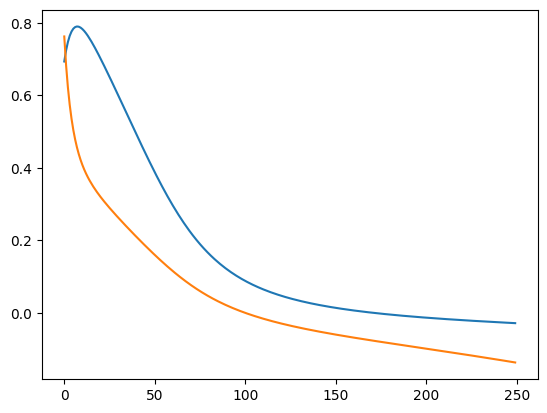

In [19]:
plt.plot(results["loss"][0::2])  # Loss at every step; prbably needs smoothing
plt.plot(results["loss"][1::2])  # Loss at every step; prbably needs smoothing
# If one graph is bigger, then it will influence the loss more heavily; explain in report, that optimally we could normalize the loss by the graph size

In [16]:
results["eval_metrics"]

{'accuracy': array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]),
 'f1-score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'x': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
        350, 375, 400, 425, 450, 475, 500])}

In [77]:
tm, vm = sklearn_train(model, train_split, valid_split, "sum")

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


#### Classical ML

In [35]:
all_data = [load_features(city, task="link_pred", format="numpy", neg_sample_ratio=50) for city in list_cities()]

In [36]:
train_split = all_data[:2]
valid_split = all_data[2: 5]

model = xgb.XGBRegressor()
model = xgb.XGBClassifier()



results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum",
    normalize_targets=False,  # Very important for link prediction
    train_criterions=["accuracy", "f1"],
    valid_criterions=["accuracy", "f1"],
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [34]:
# Look into xgb parameters to avoid overfitting
results["train_metrics"]["f1"], results["valid_metrics"]["f1"]

(0.9833172922682066, 0.14890840652446674)

#### Link prediction

In [27]:
all_data = [load_features(city, task="link_pred", format="numpy", neg_sample_ratio=3.0) 
            for city in list_cities()]

train_split = all_data[:2]
valid_split = all_data[2: 5]

model = xgb.XGBClassifier()

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum",
    normalize_targets=False,
)


Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [29]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.06330853816300129, 0.48877053388090347)